# Кластеризация доменов (тест): TFIDF + K-Means

In [1]:
# взял первые 200 доменов с текстов. выкинул NA
import pandas as pd
import numpy as np
df = pd.read_excel('sample.xlsx')
df.dropna(inplace=True)
df.head()

,Unnamed: 0,domain,text
1,1,parcedsites/mainpages/4e/82/fc/4e82fc971d8437c...,Холодильник.Ру - интернет-магазин бытовой...
3,3,parcedsites/mainpages/ef/dc/3d/efdc3d6ddb4d692...,308 Permanent Redirect 308 Permanent Redirec...
4,4,parcedsites/mainpages/53/56/1a/53561ad89c74b0f...,
5,5,parcedsites/mainpages/a4/1e/9c/a41e9c11f42834e...,
7,7,parcedsites/mainpages/32/23/67/322367b9334085b...,Best VPN service. Online security starts w...


In [2]:
# в датасете домены на разных языках. загрузил библиотеку langdetect чтобы определить язык.
# там где язык определить невозможно - выставил Not Detected
from langdetect import detect
langs = []
for i in df['text']:
    try:
        l = detect(i)
        langs.append(l)
    except:
        langs.append('Not Detected')
    continue

In [3]:
# дропнул ряды в которых невозможно определить язык
df['language'] = langs
df = df[df['language'] != 'Not Detected']
df

,Unnamed: 0,domain,text,language
1,1,parcedsites/mainpages/4e/82/fc/4e82fc971d8437c...,Холодильник.Ру - интернет-магазин бытовой...,ru
3,3,parcedsites/mainpages/ef/dc/3d/efdc3d6ddb4d692...,308 Permanent Redirect 308 Permanent Redirec...,en
7,7,parcedsites/mainpages/32/23/67/322367b9334085b...,Best VPN service. Online security starts w...,en
8,8,parcedsites/mainpages/74/3e/f3/743ef358d902290...,Итальянская обувь и одежда в Украине – Инт...,ru
9,9,parcedsites/mainpages/31/a2/88/31a288bd9f2555e...,308 Permanent Redirect 308 Permanent Redirec...,en
...,...,...,...,...
195,195,parcedsites/mainpages/0b/62/21/0b6221a9f0ac3f6...,Интернет-магазин La Roche-Posay - [скидка 1...,ru
196,196,parcedsites/mainpages/c9/30/36/c9303686b07d960...,Интернет-магазин электроники и бытовой те...,ru
197,197,parcedsites/mainpages/ed/1a/44/ed1a44c0d77fb7d...,Интернет-магазин 24shop.by: Доставка по Минску...,ru
198,198,parcedsites/mainpages/e4/69/2f/e4692fda7d1d3c7...,FitStars | видеотренир...,ru


In [4]:
# большая часть датасета на русском
df['language'].value_counts()

ru    117
en     60
uk      4
de      3
fr      2
bg      1
pl      1
ar      1
Name: language, dtype: int64

In [5]:
# решил потестить на русскоязычных доменах
df_ru = df[df['language'] == 'ru']
df_ru

,Unnamed: 0,domain,text,language
1,1,parcedsites/mainpages/4e/82/fc/4e82fc971d8437c...,Холодильник.Ру - интернет-магазин бытовой...,ru
8,8,parcedsites/mainpages/74/3e/f3/743ef358d902290...,Итальянская обувь и одежда в Украине – Инт...,ru
10,10,parcedsites/mainpages/bd/26/82/bd2682cc0c753fe...,Бука ...,ru
18,18,parcedsites/mainpages/09/0b/32/090b3294c738725...,0Кредиты онлайн на карту за 10 минут без отказ...,ru
19,19,parcedsites/mainpages/63/81/09/638109147c5d950...,Официальный интернет-магазин New Balance в...,ru
...,...,...,...,...
194,194,parcedsites/mainpages/85/c9/d8/85c9d85466a7547...,Детский интернет-магазин Helptomama ...,ru
195,195,parcedsites/mainpages/0b/62/21/0b6221a9f0ac3f6...,Интернет-магазин La Roche-Posay - [скидка 1...,ru
196,196,parcedsites/mainpages/c9/30/36/c9303686b07d960...,Интернет-магазин электроники и бытовой те...,ru
197,197,parcedsites/mainpages/ed/1a/44/ed1a44c0d77fb7d...,Интернет-магазин 24shop.by: Доставка по Минску...,ru


In [6]:
import nltk
nltk.download("stopwords")
nltk.download('punkt')
import string
from nltk.stem.snowball import SnowballStemmer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2

MORPH = pymorphy2.MorphAnalyzer() # лемматизация
stemmer = SnowballStemmer("russian") # русский стеммер
russian_stopwords = stopwords.words("russian") # русские стопворды
stemmed = []

# леммматизируем, токенизируем, обрабатываем стоп ворды, стемим
for i in df_ru['text']:
    funсtion_words = {'INTJ', 'PRCL', 'CONJ', 'PREP'}
    lemmatized_words = list(map(lambda word: MORPH.parse(word)[0], i.split()))
    result = []
    for word in lemmatized_words:
        if word.tag.POS not in funсtion_words:
            result.append(word.normal_form)
    
    clean_tokens = [word for word in result if not word in russian_stopwords]
    clean_tokens = [''.join(c for c in s if c not in string.punctuation) for s in clean_tokens]
    clean_tokens = [x for x in clean_tokens if x != '']
    temp = []
    for i in clean_tokens:
        t = stemmer.stem(i)
        temp.append(t)
    stemmed.append(temp)
    
data_final = []
for i in stemmed:
    i = " ".join(i)
    data_final.append(i)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# подцепляем обработанные тексты к датасету
df_ru['processed_text'] = data_final
df_ru.head()

<ipython-input-7-e77582f69b39>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ru['processed_text'] = data_final


,Unnamed: 0,domain,text,language,processed_text
1,1,parcedsites/mainpages/4e/82/fc/4e82fc971d8437c...,Холодильник.Ру - интернет-магазин бытовой...,ru,холодильникр интернетмагазин бытов техник холо...
8,8,parcedsites/mainpages/74/3e/f3/743ef358d902290...,Итальянская обувь и одежда в Украине – Инт...,ru,итальянск обув одежд украин – интернет магазин...
10,10,parcedsites/mainpages/bd/26/82/bd2682cc0c753fe...,Бука ...,ru,бук авторизац регистрац заб парол компан куп и...
18,18,parcedsites/mainpages/09/0b/32/090b3294c738725...,0Кредиты онлайн на карту за 10 минут без отказ...,ru,0кред онлайн карт 10 минут отказ 15 000 грн mi...
19,19,parcedsites/mainpages/63/81/09/638109147c5d950...,Официальный интернет-магазин New Balance в...,ru,официальн интернетмагазин new balance росс куп...


In [8]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
# используем TFIDF векторайзер
vectorizer = TfidfVectorizer()
vectorizer.fit(df_ru['processed_text'].values)
features = vectorizer.transform(df_ru['processed_text'].values)

In [9]:
# тестим кол-во кластеров elbow method-ом
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist 
from sklearn import metrics 
inertias = [] 
mapping = {}
num_c = range(1,11) # задаем кол-во кластеров для теста - я попробовал 10 кластеров
for i in num_c:  
    kmeanModel = KMeans(n_clusters=i, random_state=0) 
    kmeanModel.fit(features)     
    inertias.append(kmeanModel.inertia_)  
    mapping[i] = kmeanModel.inertia_ 

In [10]:
# инерция для каждого кол-ва кластеров
for key,val in mapping.items(): 
    print(str(key)+' : '+str(val)) 

1 : 111.27941284895692
2 : 109.35594252933895
3 : 107.6248584767321
4 : 105.70988871524649
5 : 104.55122205686912
6 : 102.5508498384996
7 : 101.14236611856367
8 : 99.51214963985701
9 : 98.3304357234244
10 : 97.09478096692514


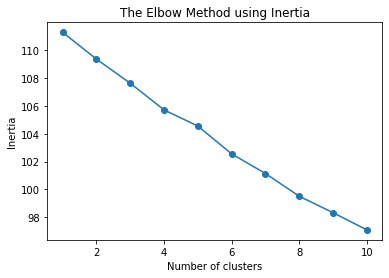

In [11]:
# график - "локтя" не видно
plt.plot(num_c, inertias, 'o-') 
plt.xlabel('Number of clusters') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

### Визуализация кластеров K-Means

In [12]:
# K-means алгоритм
cls = KMeans(n_clusters=10, random_state=0)
cls.fit(features)

KMeans(n_clusters=10, random_state=0)

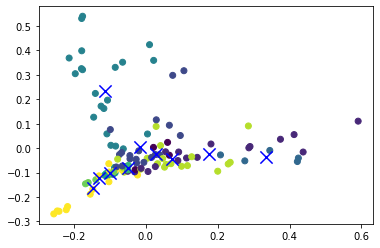

In [13]:
# уменьшаем размерность фич через PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=10, random_state=0) # кол-во компонентов = кол-во кластеров
reduced_features = pca.fit_transform(features.toarray())

reduced_cluster_centers = pca.transform(cls.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
plt.show()

In [14]:
# предсказания кластеров
pred = cls.predict(features)
pred

array([1, 4, 2, 9, 4, 4, 2, 5, 5, 8, 8, 5, 8, 4, 2, 4, 9, 9, 2, 2, 4, 4,
       9, 7, 7, 3, 2, 4, 9, 9, 3, 9, 8, 4, 2, 4, 8, 4, 4, 5, 8, 9, 8, 2,
       1, 0, 9, 8, 8, 8, 9, 2, 1, 1, 4, 2, 3, 0, 5, 8, 9, 8, 4, 2, 2, 3,
       4, 2, 1, 7, 1, 1, 1, 1, 8, 8, 4, 4, 2, 2, 1, 2, 1, 1, 2, 2, 0, 9,
       4, 2, 8, 4, 2, 7, 8, 4, 2, 9, 1, 4, 1, 2, 6, 8, 8, 3, 1, 9, 2, 7,
       4, 8, 0, 6, 1, 1, 9])

In [15]:
# подцепляем предсказания к датасету
df_ru['cluster_prediction'] = pred
df_ru

<ipython-input-15-55128b31f716>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ru['cluster_prediction'] = pred


,Unnamed: 0,domain,text,language,processed_text,cluster_prediction
1,1,parcedsites/mainpages/4e/82/fc/4e82fc971d8437c...,Холодильник.Ру - интернет-магазин бытовой...,ru,холодильникр интернетмагазин бытов техник холо...,1
8,8,parcedsites/mainpages/74/3e/f3/743ef358d902290...,Итальянская обувь и одежда в Украине – Инт...,ru,итальянск обув одежд украин – интернет магазин...,4
10,10,parcedsites/mainpages/bd/26/82/bd2682cc0c753fe...,Бука ...,ru,бук авторизац регистрац заб парол компан куп и...,2
18,18,parcedsites/mainpages/09/0b/32/090b3294c738725...,0Кредиты онлайн на карту за 10 минут без отказ...,ru,0кред онлайн карт 10 минут отказ 15 000 грн mi...,9
19,19,parcedsites/mainpages/63/81/09/638109147c5d950...,Официальный интернет-магазин New Balance в...,ru,официальн интернетмагазин new balance росс куп...,4
...,...,...,...,...,...,...
194,194,parcedsites/mainpages/85/c9/d8/85c9d85466a7547...,Детский интернет-магазин Helptomama ...,ru,детск интернетмагазин helptomama 8 800 2503314...,0
195,195,parcedsites/mainpages/0b/62/21/0b6221a9f0ac3f6...,Интернет-магазин La Roche-Posay - [скидка 1...,ru,интернетмагазин la rocheposay скидк 10 подписк...,6
196,196,parcedsites/mainpages/c9/30/36/c9303686b07d960...,Интернет-магазин электроники и бытовой те...,ru,интернетмагазин электроник бытов техник ultrat...,1
197,197,parcedsites/mainpages/ed/1a/44/ed1a44c0d77fb7d...,Интернет-магазин 24shop.by: Доставка по Минску...,ru,интернетмагазин 24shopby доставк минск рб 100 ...,1


In [16]:
# похоже что кластер 7 частично относится к тревелу
df_ru[df_ru['cluster_prediction'] == 7]

,Unnamed: 0,domain,text,language,processed_text,cluster_prediction
56,56,parcedsites/mainpages/a9/cb/a9/a9cba9f59d22ccf...,Жд билеты на поезд через Интернет: за...,ru,жд билет поезд интернет забронирова куп жд бил...,7
57,57,parcedsites/mainpages/87/ef/aa/87efaa6dad16922...,Бронирование отелей и гостини...,ru,бронирован отел гостиниц скидк 60 hotellook са...,7
127,127,parcedsites/mainpages/7c/54/95/7c54950208b4e3b...,...,ru,билет автобус поезд самолет поиск omio поездап...,7
160,160,parcedsites/mainpages/b1/7a/64/b17a646e2607471...,Билеты в театры Москвы. Купи...,ru,билет театр москв куп электрон билет театр лег...,7
191,191,parcedsites/mainpages/03/af/6f/03af6f06b778820...,"Дешевые авиабилеты онлайн, купить авиаб...",ru,дешев авиабилет онлайн куп авиабилет дешев bil...,7


# Кластеризация доменов (тест): LDA

In [195]:
# импортируем необходимые библиотеки
import re
from pprint import pprint

# библиотека Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# библиотека для визуализации тем LDA
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
%matplotlib inline

# NLTK стоп-слова
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')
stop_words.extend(['руб','год','продукт','магазин','аксессуар','товар','купить','оплата','набор','акция','кредит','карта','программа'])

In [196]:
# конверитируем данные в лист
data = df_ru['text'].values.tolist()

# очищаем от лишних символов
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]

<>:5: DeprecationWarning: invalid escape sequence \s
<ipython-input-196-418a5ff003ad>:5: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


In [197]:
# простой препроцессинг
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [198]:
# лемматизация
lemmatized = []
for i in data_words:
    funсtion_words = {'INTJ', 'PRCL', 'CONJ', 'PREP'}
    i = list(map(lambda word: MORPH.parse(word)[0], i))
    result = []
    for word in i:
        if word.tag.POS not in funсtion_words:
            result.append(word.normal_form)
    lemmatized.append(result)

In [199]:
# убираем стоп-ворды
lemmatized = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in lemmatized]

In [200]:
# стеммер
stemmed = []
for i in lemmatized:
    i = list(map(lambda word: stemmer.stem(word), i))
    stemmed.append(i)

In [201]:
# создаем словарь
id2word = corpora.Dictionary(stemmed)

# создаем корпус (TDF)
texts = stemmed
corpus = [id2word.doc2bow(text) for text in texts]

In [202]:
# находим оптимальное количество тем (цель - максимальный coherence score)
coherence_scores = []
mapping = {}
num_t = range(1,40)
for i in num_t:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=0,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=stemmed, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)
    mapping[i] = coherence_lda

In [203]:
# coherence score для каждого кол-ва тем
for key,val in mapping.items(): 
    print(str(key)+' : '+str(val)) 

1 : 0.3565064314166423
2 : 0.28704458285076795
3 : 0.3435200577169937
4 : 0.4355078084499903
5 : 0.41236667825289386
6 : 0.4159936357172885
7 : 0.4207810578068143
8 : 0.43818284837039057
9 : 0.4577258867355876
10 : 0.43252750535831863
11 : 0.4858267557132827
12 : 0.471361213570434
13 : 0.44953210140733457
14 : 0.48993601712622326
15 : 0.47438127766628935
16 : 0.502387017682859
17 : 0.48801405994447694
18 : 0.4789123735633934
19 : 0.5243108246187711
20 : 0.4936956912601496
21 : 0.5267785218731323
22 : 0.4962439978393202
23 : 0.5371588514849638
24 : 0.5285181168354365
25 : 0.5051702973627475
26 : 0.5048277662307344
27 : 0.5366930489290437
28 : 0.5329177612612492
29 : 0.5230334057168659
30 : 0.4904025963033746
31 : 0.4999450804238321
32 : 0.5181213946660593
33 : 0.4772551327048364
34 : 0.47108676628626195
35 : 0.4795673503827343
36 : 0.4885369502672297
37 : 0.4866911685358749
38 : 0.509095585131157
39 : 0.5128862897746966


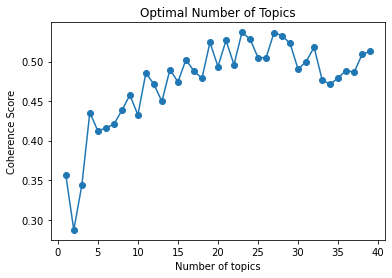

In [204]:
# график coherence score. максимальный coherence достигается на 23 темах
plt.plot(num_t, coherence_scores, 'o-') 
plt.xlabel('Number of topics') 
plt.ylabel('Coherence Score') 
plt.title('Optimal Number of Topics') 
plt.show() 

In [205]:
# строим LDA модель. оптимальное кол-во тем - 23
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=23, 
                                           random_state=0,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [206]:
# выводим ключевые слова по темам. топики 6, 16 и 1 возможно относятся к тревелу, если судить по ключевым словам
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(13,
  '0.012*"аудиоман" + 0.004*"dali" + 0.004*"mk" + 0.004*"opticon" + '
  '0.004*"audio" + 0.004*"внутриканальн" + 0.003*"aonic" + 0.003*"прослушиван" '
  '+ 0.003*"shure" + 0.002*"пластинк"'),
 (18,
  '0.006*"секс" + 0.003*"intimshop" + 0.003*"tropics" + 0.003*"эротическ" + '
  '0.002*"товарахотз" + 0.002*"оплатыпокупк" + 0.002*"шоп" + 0.002*"фаqтест" + '
  '0.002*"доставкиспособ" + 0.002*"orlando"'),
 (8,
  '0.012*"раздел" + 0.007*"кенгур" + 0.005*"зон" + 0.005*"armani" + '
  '0.004*"emporio" + 0.004*"смотрет" + 0.003*"burberry" + 0.003*"pietro" + '
  '0.003*"brunelli" + 0.003*"мес"'),
 (14,
  '0.023*"midea" + 0.014*"просмотр" + 0.013*"техник" + 0.009*"пылесос" + '
  '0.009*"быстр" + 0.008*"распродаж" + 0.008*"хит" + 0.007*"продаж" + '
  '0.006*"посудомоечн" + 0.006*"холодильник"'),
 (6,
  '0.039*"отел" + 0.017*"цен" + 0.009*"реитинг" + 0.008*"hotellook" + '
  '0.007*"дуба" + 0.007*"оаэ" + 0.006*"ангстр" + 0.006*"средн" + '
  '0.005*"доллар" + 0.005*"ноч"'),
 (10,
  '0.034*"мест"

In [207]:
# считаем perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -10.468596546493744


### Визулизация тем LDA

In [208]:
# есть возможность визуализировать темы через библиотеку pyLDAvis. Топики 10, 13, 19 - возможно относятся к тревелу
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.231806 -0.264963       1        1  15.704423
9      0.255786  0.101808       2        1  14.916769
20     0.250682 -0.204604       3        1  11.019142
7      0.219667  0.178955       4        1  10.425286
12     0.262032  0.055207       5        1  10.111284
3      0.240740  0.139709       6        1   7.407851
2      0.088786  0.109440       7        1   6.872021
5     -0.066271  0.039109       8        1   4.508467
21     0.125531 -0.125380       9        1   3.426486
1     -0.032610  0.040766      10        1   2.314169
0     -0.117157 -0.014609      11        1   2.028629
17    -0.105368 -0.031766      12        1   1.928828
16    -0.064763  0.035934      13        1   1.904916
4     -0.086281 -0.013276      14        1   1.868688
22    -0.109561 -0.040168      15        1   1.377890
11    -0.135513 -0.006051      16        1   1.052496
10    -0.129046  0.019308      17        1   0.884667
19    -0.140637  0.005755      18        1   0.693370
6     -0.135113  0.006378      19        1   0.657424
14    -0.133369 -0.022201      20        1   0.447962
8     -0.140762 -0.002703      21        1   0.307141
13    -0.139481 -0.003341      22        1   0.081978
18    -0.139099 -0.003306      23        1   0.060118, topic_info=          Term        Freq       Total Category  logprob  loglift
12238      квт  217.000000  217.000000  Default  30.0000  30.0000
1380     мебел  365.000000  365.000000  Default  29.0000  29.0000
862      одежд  344.000000  344.000000  Default  28.0000  28.0000
534     техник  291.000000  291.000000  Default  27.0000  27.0000
2174       кож  249.000000  249.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
180        дом    0.003634  362.413544  Topic23  -9.7529  -4.0935
318        наш    0.003631  360.167511  Topic23  -9.7536  -4.0881
367    отношен    0.003631   16.334003  Topic23  -9.7537  -0.9949
1740   сентябр    0.003630    5.635882  Topic23  -9.7540   0.0690
562       уход    0.003629  329.533112  Topic23  -9.7542  -3.9998

[1285 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
13785      8  0.900895  acuvue
9967      17  0.611472   aizel
14453     21  0.712883  allude
14385     20  0.628564      an
8929       3  0.179672   apple
...      ...       ...     ...
1822      19  0.087373  японск
1823       1  0.092742    ящик
1823       5  0.074193    ящик
1823       9  0.816128    ящик
2307      19  0.721022  քдобав

[2550 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 10, 21, 8, 13, 4, 3, 6, 22, 2, 1, 18, 17, 5, 23, 12, 11, 20, 7, 15, 9, 14, 19])

P.S. Пока не разобрался как подцепить предсказанные топики LDA к датасету. 